In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.optimize import  minimize,NonlinearConstraint #optimization

### Fitting functions

In [2]:
from math import *
# Functions and Definitions for Data fitting
COP_DATA = []         
COP_POLY_COEFFS = np.array([])  
COP_POLY_DEGREE = 3   

HEAT_POLY_COEFFS = np.array([])  # will store polynomial coefficients
HEAT_POLY_DEGREE = 3             # adjust as needed

def generate_heat_fit(heat_dict):
    global HEAT_POLY_COEFFS

    if not heat_dict:
        raise ValueError("No heat data to fit.")

    # Sort by temperature
    temps, heat_vals = zip(*sorted(heat_dict.items()))
    heat_vals = [i for i in heat_vals]
    # Fit polynomial
    HEAT_POLY_COEFFS = np.polyfit(temps, heat_vals, HEAT_POLY_DEGREE)


def get_heat_from_fit(T):
    if HEAT_POLY_COEFFS is None or len(HEAT_POLY_COEFFS) == 0:
        raise RuntimeError("Heat polynomial fit has not been generated.")
    
    return float(np.polyval(HEAT_POLY_COEFFS, T))


def print_heat_fit_equation():
    terms = [f"{coef:.6g} * T^{HEAT_POLY_DEGREE - i}" 
            for i, coef in enumerate(HEAT_POLY_COEFFS)]
    equation = " + ".join(terms)
    print("Heat(T) ≈", equation)



def store_COP_data(param, T_si_in):
    cop_val = 1. / calc_COP(param)  # invert reciprocal COP
    COP_DATA.append((T_si_in, cop_val))
    return 1. / cop_val

def generate_COP_fit():
    global COP_POLY_COEFFS
    if not COP_DATA:
        raise ValueError("No COP data to fit.")
    COP_DATA.sort(key=lambda x: x[0])
    T_vals, cop_vals = zip(*COP_DATA)
    COP_POLY_COEFFS = np.polyfit(T_vals, cop_vals, COP_POLY_DEGREE)

def get_COP_from_fit(T_si_in,Q_demand):#returns COP_res
    if COP_POLY_COEFFS is None or len(COP_POLY_COEFFS) == 0:
        raise RuntimeError("COP polynomial fit has not been generated.")
    Q_hp = get_heat_from_fit(T_si_in)
    factor = (Q_demand/Q_hp)/(0.9*Q_demand/Q_hp + 0.1)
    
    return float(np.polyval(COP_POLY_COEFFS, T_si_in)) * (factor)

def calc_COP(param): 
    hp_vals = HP(param)

    state1 = hp_vals["state1"]

    state3= hp_vals["state3"]

    state2= hp_vals["state2"]

    #spec. heat released in the condenser
    q_high=state2["h"]-state3["h"] #kJ/kg
    #spec. compressor work
    w_comp=state2["h"]-state1["h"]  #kJ/kg
    #coefficient of performance 

    COP=q_high/w_comp
    #return reciprocal value of COP
    return 1./COP

def print_COP_fit_equation():
    if len(COP_POLY_COEFFS) == 0:
        raise RuntimeError("Fit not generated yet.")

    terms = [f"{coef:.6g} * T^{COP_POLY_DEGREE - i}" 
        for i, coef in enumerate(COP_POLY_COEFFS)]
    equation = " + ".join(terms)
    print("COP(T_si_in) ≈", equation)


### Reading in file with Heat and COP data for fitting

In [3]:
#read in textfile

def read_results_from_txt(filepath="heat_pump_results.txt"):
    results = {}
    current_dia = None
    current_fluid = None
    mode = None

    with open(filepath, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue

            if line.startswith("DIA="):
                parts = line.split(", ")
                current_dia = int(parts[0].split("=")[1])
                current_fluid = parts[1].split("=")[1]

                if current_dia not in results:
                    results[current_dia] = {}

                results[current_dia][current_fluid] = {
                    "COP_DATA": [],
                    "HEAT_DATA": {}
                }

            elif line == "COP_DATA:":
                mode = "COP_DATA"

            elif line == "HEAT_DATA:":
                mode = "HEAT_DATA"

            elif line == "END_ENTRY":
                mode = None
                current_dia = None
                current_fluid = None

            elif mode == "COP_DATA":
                T, cop = map(float, line.split(","))
                results[current_dia][current_fluid]["COP_DATA"].append((T, cop))

            elif mode == "HEAT_DATA":
                T, Q = map(float, line.split(","))
                results[current_dia][current_fluid]["HEAT_DATA"][T] = Q

    return results

In [4]:
results = read_results_from_txt("heat_pump_results.txt")

COP_DATA = []
HEAT_DATA = {}

COP_DATA = results[35]['Isobutane']['COP_DATA']

HEAT_DATA = results[35]['Isobutane']['HEAT_DATA']

In [5]:
generate_COP_fit() #generates fit for exactly these conditions: power, diameter, refrigerant
generate_heat_fit(HEAT_DATA)

## Control Strategy with heat-up included

### Defining variables

In [6]:
# --- Global control variables ---
HP = 1  # initial state of the heat pump: 1 = ON, 0 = OFF
time = 0  # timer to record operating time

# --- Constants and parameters ---
R_env = 30 / 1000    # K/W£
R_pasta = 15 / 1000  # K/W
c_l = 4.18 * 1000    # J/kg·K water
c_pasta = 3.5 * 1000 # J/kg·K pasta

T_env = 20      # °C
T_pasta_0 = 7        # °C
rho_water = 997.     # kg/m3

# --- Dimensions of the water tank ---
V_water = (47 - 0.4) * (27 - 0.4) * (20 - 0.2) / 1000# L
m_water = V_water / 1e3 * rho_water  # kg
m_pasta = 2 # kg

print(V_water)

24.543288000000004


### Defining pasta cooking schedule 

In [7]:
# --- Pasta batch schedule (7 min cook, 5 min break) ---
# could also be adapted if a new schedule was needed
def make_pasta_list(t):
    #counter_heating = heating_up_time * 60  # convert to seconds
    pasta_counter = 7 * 60
    break_counter = 5 * 60
    pasta_presence = np.zeros(len(t))
    pasta_taking_out_times = np.zeros(len(t))
    
    for i in range(len(t)):
        #if counter_heating > 0:
            #counter_heating -= 1
            #pasta_presence[i] = 0
            #continue
        if pasta_counter == 0:
            pasta_taking_out_times[i] = 1
        if pasta_counter > 0:
            pasta_presence[i] = 1
            pasta_counter -= 1
        elif break_counter > 0:
            pasta_presence[i] = 0
            break_counter -= 1
        else:
            pasta_counter = 7 * 60 - 1
            break_counter = 5 * 60
            pasta_presence[i] = 1
    return pasta_presence

def make_pasta_starting_list(t):
    pasta_counter = 7 * 60
    break_counter = 5 * 60
    pasta_presence = np.zeros(len(t))
    pasta_taking_out_times = np.zeros(len(t))
    #counter_heating = heating_up_time * 60  # convert to seconds
    
    for i in range(len(t)):
        #if counter_heating > 0:
            #counter_heating -= 1
            #pasta_presence[i] = 0
            #continue
        if pasta_counter == 1:
            pasta_taking_out_times[i] = 1
        if pasta_counter > 0:
            pasta_presence[i] = 1
            pasta_counter -= 1
        elif break_counter > 0:
            pasta_presence[i] = 0
            break_counter -= 1
        else:
            pasta_counter = 7 * 60 - 1
            break_counter = 5 * 60
            pasta_presence[i] = 1
    return pasta_taking_out_times

### Define heat pump control logic

In [8]:
# --- Heat pump control logic ---
def calc_HP(T, T_on, T_off, op_times):
    global HP, time

    # time counts how long the heat pump operates for one operation
    # HP signals if the heatpump is on or off

    # If Temperature falls below minimal threshold value --> turn heat pump on
    if T <= T_on: # Temperature is below T
        if HP == 0:
            time = 0
        HP = 1

    # If Temperature is above maximum threshold --> turn heat pump off
    elif T >= T_off:
        if HP == 1:
            op_times.append(time)
        HP = 0

    # If the Heatpump is on, increase operation time and calculate heat output for the respective sink temperature with the fit
    # Else output of the heatpump is zero at this timestel
    if HP == 1:
        time += 1
        return get_heat_from_fit(T) * 1000
    else:
        return 0

### Define Temperature ODE's for system

In [9]:
# --- ODE for water only ---
def temp_store_only_water(T_water, t, Q_WP, m_water, c_water):
    dT_waterdt = (Q_WP - (T_water - T_env) / R_env) / (m_water * c_water)
    return dT_waterdt

# --- ODE for water + pasta ---
def temp_store_with_pasta(T, t, Q_WP, m_water, m_pasta, c_water, c_pasta):
    T_water, T_pasta = T
    dT_waterdt = (Q_WP - (T_water - T_env) / R_env - (T_water - T_pasta) / R_pasta) / (m_water * c_water)
    dT_pastadt = ((T_water - T_pasta) / R_pasta) / (m_pasta * c_pasta)
    return [dT_waterdt, dT_pastadt]

### Define the main simulation

In [10]:
# --- Main simulation ---

def T_water_and_pasta(T_WP_on, T_WP_off, duration_s,op_times, V_store):
    t = np.linspace(0, duration_s, duration_s)
    T_water = np.zeros(duration_s)
    T_pasta = np.full(duration_s, T_pasta_0, dtype=float)
    Q_WPs = np.zeros(duration_s)
    Q_demand = np.zeros(duration_s)

    T0_water = T_WP_on
    T0_pasta = T_pasta_0
    T_water[0] = T0_water
    T_pasta[0] = T0_pasta

    m_store = V_store / 1e3 * rho_water
    m_pasta = 2  # kg

    binary_pasta = make_pasta_list(t)

    global WP, time
    WP = 1
    time = 0

    for i in range(1, duration_s):
        if binary_pasta[i] == 0:
            tspan = [t[i - 1], t[i]]
            z = odeint(temp_store_only_water, T0_water, tspan, args=(Q_WPs[i - 1], m_store, c_l))
            T0_water = z[1][0]
            T0_pasta = T_pasta_0
            Q_demand[i] = m_store * c_l * (T0_water - T_water[i - 1])
        else:
            tspan = np.linspace(t[i - 1], t[i], 10)
            T_function = [T0_water, T0_pasta]
            sol = odeint(temp_store_with_pasta, T_function, tspan, args=(Q_WPs[i - 1], m_store, m_pasta, c_l, c_pasta))
            T0_water = sol[-1, 0]
            T0_pasta = sol[-1, 1]
            Q_demand[i] = (
                m_store * c_l * (T0_water - T_water[i - 1]) +
                m_pasta * c_pasta * (T0_pasta - T_pasta[i - 1])
                )

        Q_WPs[i] = calc_HP(T0_water, T_WP_on, T_WP_off, op_times)
        T_water[i] = T0_water
        T_pasta[i] = T0_pasta

    return t, Q_WPs, T_water, T_pasta, Q_demand


# --- Main simulation with morning heat-up ---
def T_water_and_pasta_with_heatup(T_WP_on, T_WP_off, V_water, duration_s, op_times, m_water, m_pasta):
    t = np.linspace(0, duration_s, duration_s)
    T_water = np.zeros(duration_s)
    T_pasta = np.full(duration_s, T_pasta_0, dtype=float)
    Q_WPs = np.zeros(duration_s)
    #Q_pasta = np.zeros(duration_s)

    T0_water = T_env  # Start at room temp
    T0_pasta = T_pasta_0
    T_water[0] = T0_water
    T_pasta[0] = T0_pasta

    binary_pasta = np.zeros(duration_s)
    
    pasta_schedule_started = False
    pasta_schedule_start_index = None

    for i in range(1, duration_s):
        if not pasta_schedule_started and T0_water >= T_WP_on:
            pasta_schedule_start_index = i
            binary_pasta[i:] = make_pasta_list(np.arange(duration_s - i))
            pasta_schedule_started = True

        if binary_pasta[i] == 0:
            tspan = [t[i - 1], t[i]]
            z = odeint(temp_store_only_water, T0_water, tspan, args=(Q_WPs[i - 1], m_water, c_l))
            T0_water = z[1][0]
            T0_pasta = T_pasta_0

        else:
            tspan = np.linspace(t[i - 1], t[i], 10)
            T_function = [T0_water, T0_pasta]
            sol = odeint(temp_store_with_pasta, T_function, tspan, args=(Q_WPs[i - 1], m_water, m_pasta, c_l, c_pasta))
            T0_water = sol[-1, 0]
            T0_pasta = sol[-1, 1]

        Q_WPs[i] = calc_HP(T0_water, T_WP_on, T_WP_off, op_times)
        T_water[i] = T0_water
        T_pasta[i] = T0_pasta
        #Q_pasta[i] = m_pasta*c_pasta*(T_pasta[i] - T_pasta[i-1])

    return t, Q_WPs, T_water, T_pasta, pasta_schedule_start_index


### Running the simulation

#### Calculate additional time needed for heating up in the morning

#### Run simulation for the 12 hours of operation including the heating up time in the morning

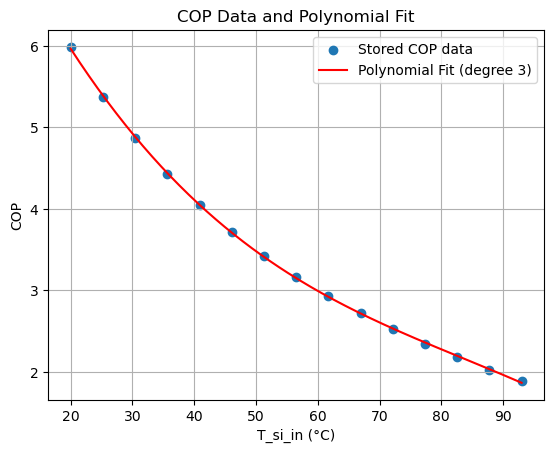

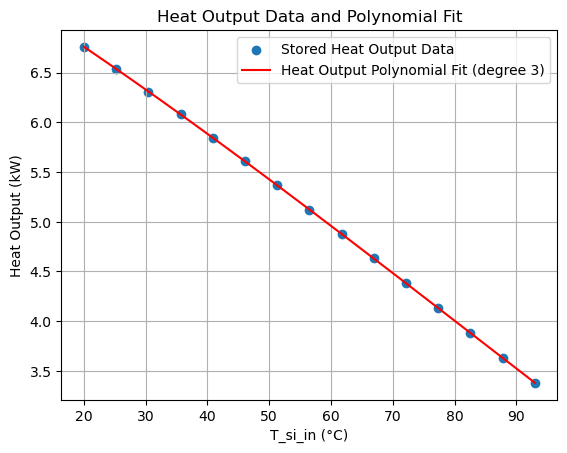

In [11]:
    # Plotting the data points and the fit
plt.scatter(*zip(*COP_DATA), label='Stored COP data')

T_plot = np.linspace(20, 93, 200)
COP_fit_vals = [get_COP_from_fit(T, get_heat_from_fit(T)) for T in T_plot]

plt.plot(T_plot, COP_fit_vals, 'r-', label='Polynomial Fit (degree {})'.format(COP_POLY_DEGREE))
plt.xlabel('T_si_in (°C)')
plt.ylabel('COP')
plt.title('COP Data and Polynomial Fit')
plt.legend()
plt.grid(True)
plt.show()

#plotting heat output data
plt.scatter(*zip(*HEAT_DATA.items()), label='Stored Heat Output Data')
T_heat_plot = np.linspace(20, 93, 200)
heat_fit_vals = [get_heat_from_fit(T) for T in T_heat_plot]
plt.plot(T_heat_plot, heat_fit_vals, 'r-', label='Heat Output Polynomial Fit (degree {})'.format(HEAT_POLY_DEGREE))
plt.xlabel('T_si_in (°C)')
plt.ylabel('Heat Output (kW)')
plt.title('Heat Output Data and Polynomial Fit')
plt.legend()
plt.grid(True)
plt.show()


In [12]:
### get power demand for heating up phase 


### Alternative with grid search

In [13]:
import numpy as np
import itertools

# Clear log file
with open("grid_search_log.txt", "w") as f:
    f.write("T_on,T_off,Valid,Power_kWh,Min_T,Max_T,Pasta_Ts\n")
    
# --- Global setup ---
global V_water, duration_seconds, m_water, m_pasta, T_WP_on, T_WP_off
duration_seconds = 12 * 60 * 60  # 12 hours
start_index = 0

t = np.linspace(0, duration_seconds, duration_seconds)  # 1-second resolution
binary_pasta = make_pasta_list(t)
binary_taking_out_pasta = make_pasta_starting_list(t)

T_on_range = np.linspace(86.5, 89, 10)
T_off_range = np.linspace(88, 93, 10)
duration_seconds = 12*60*60

best_result = None
best_power = np.inf
results = []

for T_on, T_off in itertools.product(T_on_range, T_off_range):
    if T_on >= T_off:
        continue

    try:
        t, Q_WP, T_water, T_pasta, Q_demand = T_water_and_pasta(T_on, T_off, duration_seconds, [], V_water)

        min_T = np.min(T_water)
        max_T = np.max(T_water)
        end_pasta_Ts = T_pasta[np.where(binary_taking_out_pasta == 1)]
        valid_water_range = 85 <= min_T and max_T <= 93
        valid_pasta_range = np.all((85 <= end_pasta_Ts) & (end_pasta_Ts <= 86))

        if not (valid_water_range and valid_pasta_range):
            # Log invalid
            with open("grid_search_log.txt", "a") as f:
                f.write(f"{T_on:.2f},{T_off:.2f},False,NA,{min_T:.2f},{max_T:.2f},{end_pasta_Ts.tolist()}\n")
            continue

        # Calculate objective
        power = 0
        for i in range(len(Q_WP)):
            if Q_WP[i] > 0:
                cop = max(get_COP_from_fit(T_water[i], Q_demand[i]), 0.01)
                power += Q_WP[i] / (cop * 1000)

        results.append((T_on, T_off, power))

        if power < best_power:
            best_power = power
            best_result = (T_on, T_off)

        print(f"✅ T_on: {T_on:.2f}, T_off: {T_off:.2f}, Power: {power:.2f} kWh")

        # Log valid
        with open("grid_search_log.txt", "a") as f:
            f.write(f"{T_on:.2f},{T_off:.2f},True,{power:.2f},{min_T:.2f},{max_T:.2f},{end_pasta_Ts.tolist()}\n")

    except Exception as e:
        print(f"⚠️ Failed for T_on = {T_on:.2f}, T_off = {T_off:.2f}: {e}")
        with open("grid_search_log.txt", "a") as f:
            f.write(f"{T_on:.2f},{T_off:.2f},Error,NA,NA,NA,NA\n")

# --- Final Output ---
if best_result:
    print(f"\n🎯 Best combination: T_on = {best_result[0]:.2f}, T_off = {best_result[1]:.2f}, Power = {best_power:.2f} kWh")
else:
    print("\n❌ No valid combination found.")


✅ T_on: 87.06, T_off: 88.00, Power: 56652.04 kWh


KeyboardInterrupt: 

In [ ]:
# --- Plot results using the best found T_on and T_off ---
T_WP_on, T_WP_off = best_result

# Run simulation with best parameters
op_times = []
t, Q_WPs, T_water, T_pasta,_ = T_water_and_pasta(
    T_WP_on, T_WP_off, duration_seconds, op_times, V_water
)

# --- Plot results ---
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(20, 10))
ax1.plot(t / 60, T_water, 'r-', label='T_water [°C]')
if start_index:
    ax1.axvline(t[start_index] / 60, color='blue', linestyle='--', label='Start of Cooking')
ax1.set_ylabel('T_water [°C]')
ax1.legend()
ax2.plot(t / 60, Q_WPs / 1000, 'g-', label='Q_HP [kW]')
ax2.set_xlabel('Time [minutes]')
ax2.set_ylabel('Heat Pump Power [kW]')
ax2.legend()
ax3.plot(t / 60, T_pasta, 'b-', label='T_pasta [°C]')
ax3.set_ylabel('T_pasta [°C]')
ax3.legend()

plt.tight_layout()
plt.show()

# --- Compute and show summary ---
min_op = round(min(op_times) / 60., 2) if op_times else 0
max_op = round(max(op_times) / 60., 2) if op_times else 0
num_cycles = len(op_times)
heatup_time_min = round(t[start_index] / 60, 2) if start_index else "N/A"
total_duration = duration_seconds / 60 / 60 

print("Time until cooking starts (heat-up) =", heatup_time_min, "minutes")
print("Min operating time =", min_op, "minutes")
print("Max operating time =", max_op, "minutes")
print("Number of heat pump on-cycles =", num_cycles)
print("total_duration =", total_duration, "hours")
print("Max T_water after heat-up:", max(T_water))
print("Min T_water after heat-up:", min(T_water))
print("Max T_pasta:", max(T_pasta))


TypeError: cannot unpack non-iterable NoneType object

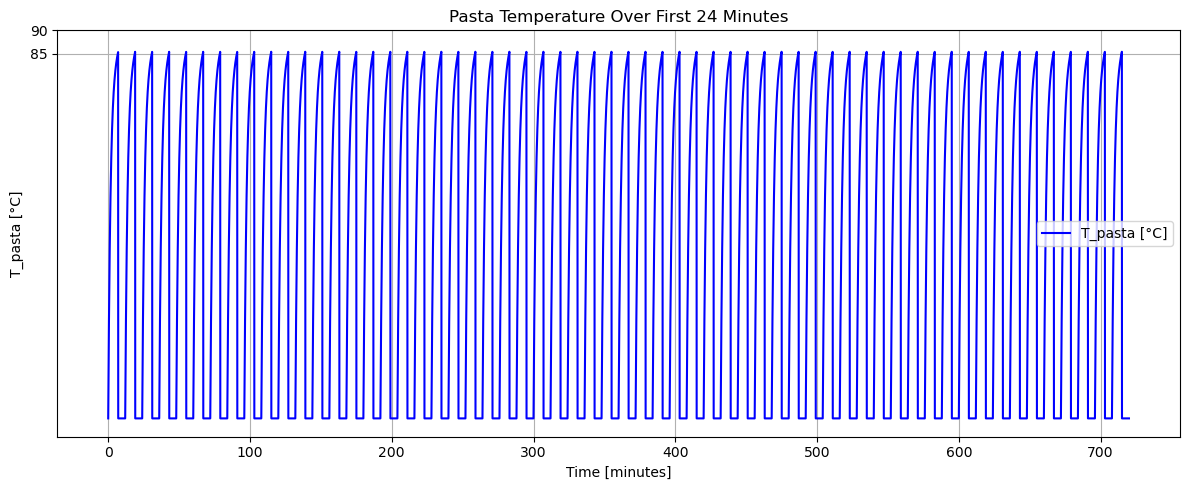

In [53]:
import matplotlib.pyplot as plt
import numpy as np

# Limit to the first 24 minutes
time_limit_minutes = 60 * 12
time_limit_seconds = time_limit_minutes * 60

# Create a mask for time ≤ 24 minutes
mask = t <= time_limit_seconds

# Apply the mask to time and temperature arrays
t_limited = t[mask]
T_pasta_limited = T_pasta[mask]

plt.figure(figsize=(12, 5))
plt.plot(t_limited / 60, T_pasta_limited, 'b-', label='T_pasta [°C]')
plt.xlabel('Time [minutes]')
plt.ylabel('T_pasta [°C]')
plt.title('Pasta Temperature Over First 24 Minutes')
plt.grid(True)
plt.legend()

# Set y-axis ticks at 85 and 90 °C
plt.yticks([85, 90])

plt.tight_layout()
plt.show()




### after first screening for the best solutions

In [ ]:
import numpy as np
from scipy.optimize import minimize, NonlinearConstraint
#clear log 
open("optimization_log.txt", "w").close()

T_on_approx,T_off_approx = best_result

# --- Global setup ---
global V_water, duration_seconds, m_water, m_pasta, T_WP_on, T_WP_off
duration_seconds = 12 * 60 * 60  # 12 hours
start_index = 0

t = np.linspace(0, duration_seconds, duration_seconds)  # 1-second resolution
binary_pasta = make_pasta_list(t)
binary_taking_out_pasta = make_pasta_starting_list(t)

# --- Constraints ---
def water_temp_min_constraint(x):
    T_WP_on, T_WP_off = x
    _, _, T_water, _,_ = T_water_and_pasta(T_WP_on, T_WP_off, duration_seconds, [], V_water)
    return np.min(T_water)

def water_temp_max_constraint(x):
    T_WP_on, T_WP_off = x
    _, _, T_water, _,_ = T_water_and_pasta(T_WP_on, T_WP_off, duration_seconds, [], V_water)
    return np.max(T_water)

def pasta_temp_at_cycle_ends_constraint(x):
    T_WP_on, T_WP_off = x
    _, _, _, T_pasta,_ = T_water_and_pasta(T_WP_on, T_WP_off, duration_seconds, [], V_water)
    cycle_end_indices = np.where(binary_taking_out_pasta == 1)[0]
    return T_pasta[cycle_end_indices]

# --- Constraints setup ---
nlc_min = NonlinearConstraint(water_temp_min_constraint, 85., np.inf)
nlc_max = NonlinearConstraint(water_temp_max_constraint, -np.inf, 93)
nlc_pasta_min = NonlinearConstraint(pasta_temp_at_cycle_ends_constraint, 85, np.inf)
nlc_pasta_max = NonlinearConstraint(pasta_temp_at_cycle_ends_constraint, -np.inf, 87)
constraints = [nlc_min, nlc_max, nlc_pasta_min, nlc_pasta_max]

# --- Objective Function ---
def objective(x):
    T_WP_on, T_WP_off = x
    global WP, time
    WP = 0
    time = 0
    op_times = []
    t, Q_WP, T_water, _ ,Q_demand= T_water_and_pasta(T_WP_on, T_WP_off, duration_seconds, op_times, V_water)

    power_consumption = []
    for i in range(len(Q_WP)):
        
        if Q_WP[i] > 0:
            cop1 = get_COP_from_fit(T_water[i],Q_demand[i])
            
            cop = max(cop1, 0.01)
            power = Q_WP[i] / (cop * 1000)  # Convert to kWh
        else:
            power = 0
        power_consumption.append(power)

    total_power = np.sum(power_consumption)

    # Logging
    with open("optimization_log.txt", "a") as log_file:
        log_file.write(f"T_on = {T_WP_on:.2f}, T_off = {T_WP_off:.2f}, Power = {total_power:.2f} kWh\n")

    return total_power

best_result = None
best_obj = float('inf')

# --- Run Optimization with Random Restarts ---
for i in range(3):  # Try 3 different starting points
    x0 = np.random.uniform(low=[T_on_approx-0.5, T_off_approx-0.5], high=[T_on_approx+0.5, T_off_approx+0.5])
    print(f"\n🔁 Starting optimization {i+1}/3 with x0 = {x0}")

    result = minimize(
        objective,
        x0=x0,
        bounds=[(87, 90), (88, 93)],
        constraints=constraints,
        method='SLSQP',
        options={
            'disp': False,     # Set to True if you want per-iteration logs
            'maxiter': 200,
            'eps': 0.25,       # Larger initial step size
            'ftol': 1e-2       # Relaxed final accuracy
        }
    )

    if result.success and result.fun < best_obj:
        best_result = result
        best_obj = result.fun

# --- Report Best Result ---
if best_result:
    print("\n✅ Best Result Across All Starts:")
    print(f"T_on  = {best_result.x[0]:.2f} °C")
    print(f"T_off = {best_result.x[1]:.2f} °C")
    print(f"Total Heat Pump Power = {best_obj:.2f} kWh")
else:
    print("\n❌ Optimization failed for all initial guesses.")
    print(result.message)



In [ ]:
# --- Plot results using the best found T_on and T_off ---
#T_WP_on, T_WP_off = best_result
#T_on = 87.23, T_off = 91.07, Power = 58505.43 kWh
T_WP_on = 87.23
T_WP_off = 91.07
# Run simulation with best parameters
op_times = []
t, Q_WPs, T_water, T_pasta,_ = T_water_and_pasta(
    T_WP_on, T_WP_off, duration_seconds, op_times, V_water
)

# --- Plot results ---
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(20, 10))
ax1.plot(t / 60, T_water, 'r-', label='T_water [°C]')
if start_index:
    ax1.axvline(t[start_index] / 60, color='blue', linestyle='--', label='Start of Cooking')
ax1.set_ylabel('T_water [°C]')
ax1.legend()
ax2.plot(t / 60, Q_WPs / 1000, 'g-', label='Q_HP [kW]')
ax2.set_xlabel('Time [minutes]')
ax2.set_ylabel('Heat Pump Power [kW]')
ax2.legend()
ax3.plot(t / 60, T_pasta, 'b-', label='T_pasta [°C]')
ax3.set_ylabel('T_pasta [°C]')
ax3.legend()

plt.tight_layout()
plt.show()

# --- Compute and show summary ---
min_op = round(min(op_times) / 60., 2) if op_times else 0
max_op = round(max(op_times) / 60., 2) if op_times else 0
num_cycles = len(op_times)
heatup_time_min = round(t[start_index] / 60, 2) if start_index else "N/A"
total_duration = duration_seconds / 60 / 60 

print("Time until cooking starts (heat-up) =", heatup_time_min, "minutes")
print("Min operating time =", min_op, "minutes")
print("Max operating time =", max_op, "minutes")
print("Number of heat pump on-cycles =", num_cycles)
print("total_duration =", total_duration, "hours")
print("Max T_water after heat-up:", max(T_water))
print("Min T_water after heat-up:", min(T_water))
print("Max T_pasta:", max(T_pasta))


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Limit to the first 24 minutes
time_limit_minutes = 60 * 12
time_limit_seconds = time_limit_minutes * 60

# Create a mask for time ≤ 24 minutes
mask = t <= time_limit_seconds

# Apply the mask to time and temperature arrays
t_limited = t[mask]
T_pasta_limited = T_pasta[mask]

plt.figure(figsize=(12, 5))
plt.plot(t_limited / 60, T_pasta_limited, 'b-', label='T_pasta [°C]')
plt.xlabel('Time [minutes]')
plt.ylabel('T_pasta [°C]')
plt.title('Pasta Temperature Over First 24 Minutes')
plt.grid(True)
plt.legend()

# Set y-axis ticks at 85 and 90 °C
plt.yticks([85, 90])

plt.tight_layout()
plt.show()


